In [1]:
##Import packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
##Import data and specify input features, target values
X = []
Y = []

def sanitize(row):
    if all([row[1], row[2], row[3], row[4], row[5], row[6], row[7]]):
        return [float(row[1]), #tidally filtered discharge (cfs)
                float(row[2]), #dissolved oxygen (mg/L)
                float(row[3]), #water temperature (deg C)
                float(row[4]), #air temperature (deg F)
                float(row[5]), #precipitation (in)
                float(row[6])  #specific conductance (uS/L)
                ]
    else:
        return False

import csv
with open('C:\\Users\\morga\\CE510\\Final\\FinalData.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)
    for row in reader:
        if sanitize(row):
            X.append(sanitize(row))
            Y.append(float(row[7]))

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(940, 6)
(940,)


In [51]:
#Set aside a testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 637)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 842)

#Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#Define m and n using input features
m = len(X_train)
n = len(X_train[0]) +1
print("m = ", m)
print("n = ", n)

#Create a special test set for high precipitation events
from statistics import mean
precip = []
for row in X_test:
    precip.append(row[4])
mean_precip = mean(precip)

precip_test_X = []
precip_test_Y = []
for i, row in enumerate(X_test):
    if row[4] > mean_precip:
        precip_test_X.append(row)
        precip_test_Y.append(Y_test[i])
precip_test_X = np.array(precip_test_X)
precip_test_Y=np.array(precip_test_Y)
print(len(precip_test_X))
print(len(precip_test_Y))

m =  752
n =  7
17
17


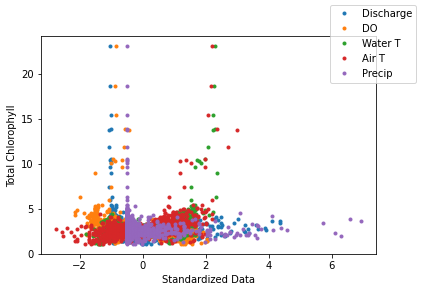

In [21]:
#Data visualization
fig, ax = plt.subplots(1,1)
discharge = []
DO = []
watertemp = []
airtemp = []
precip = []
for row in X_train:
    discharge.append(row[0])
    DO.append(row[1])
    watertemp.append(row[2])
    airtemp.append(row[3])
    precip.append(row[4])
    
ax.plot(discharge, Y_train, '.')
ax.plot(DO, Y_train, '.')
ax.plot(watertemp, Y_train, '.')
ax.plot(airtemp, Y_train, '.')
ax.plot(precip, Y_train, '.')
ax.set_ylabel('Total Chlorophyll')
ax.set_xlabel('Standardized Data')
plt.figlegend(
    ('Discharge', 'DO', 'Water T', 'Air T', 'Precip'))

Notes on visualization:
Discharge and DO are negatively correlated with chlorophyll content.
Water temp, air temp, and precipitation are positively correlated with chlorophyll content.
Higher temp and lower discharge correspond with summertime conditions, where chlorophyll levels are typically higher.
Higher precipitation results in higher chlorophyll content as nutrients are washed into the waterway.
DO is likely more complex since algae interacts with oxygen. (Produces during day, consumes during night, consumes upon death)

## Support Vector Machine

In [5]:
#Build a regression model using SVM, use a systematic search to optimize hyperparameters
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR(kernel='rbf',epsilon=1,C=1.0, degree=2)
params_ = {
    "kernel": ['rbf', 'linear', 'poly'],
    "epsilon": [0.1, 1, 10],
    "C": [1, 10],
    "degree": [1,2,3]
}

svr_cv = GridSearchCV(svr, params_, verbose=1, scoring = 'r2')
svr_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=SVR(degree=2, epsilon=1),
             param_grid={'C': [1, 10], 'degree': [1, 2, 3],
                         'epsilon': [0.1, 1, 10],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='r2', verbose=1)

In [52]:
#Model validation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print(svr_cv.best_params_)
print(f"R2 of training set is {svr_cv.best_score_}")

Y_pred = svr_cv.predict(X_val)
r2_svr = r2_score(Y_val, Y_pred)
print(f"R2 of validation set is {r2_svr}")

Y_pred = svr_cv.predict(X_test)
r2_test = r2_score(Y_test, Y_pred)
print(f"R2 of test set is {r2_svr}")
mse_test = mean_squared_error(Y_test,Y_pred)
print(f'MSE of test set is {mse_test}')

Y_pred = svr_cv.predict(precip_test_X)
r2_precip = r2_score(precip_test_Y, Y_pred)
print(f"R2 of high precipitation set is {r2_precip}")

from sklearn.inspection import permutation_importance
res = permutation_importance(svr_cv, X_train, Y_train, scoring='r2', n_repeats=5, random_state=42)
p_importances = res['importances_mean']/res['importances_mean'].sum()
print(f"The permutation-based feature importance is {p_importances}")

{'C': 10, 'degree': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
R2 of training set is 0.8266815826246396
R2 of validation set is 0.8528204767570464
R2 of test set is 0.8528204767570464
MSE of test set is 0.40184636420567676
R2 of high precipitation set is 0.49588270474474294
The permutation-based feature importance is [0.16861253 0.4350888  0.29144433 0.04559628 0.01279399 0.04646408]


## Artificial Neural Network

In [7]:
#Import packages for ANN
import tensorflow as tf
from tensorflow import keras
print(f"TensorFlow version is {tf.__version__}")
print(f"Keras version is {keras.__version__}")

TensorFlow version is 2.4.1
Keras version is 2.4.0


In [8]:
#Clear models, set seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Editable values
n_epochs = 100
n_hidden = 2
n_neurons = 20
act_func = 'relu'

In [9]:
#ANN using SGD optimizer
#Tested a few layer structures to find low mean squared error
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

ann_sgd = keras.models.Sequential()
for layer in range(n_hidden):
    ann_sgd.add(keras.layers.Dense(n_neurons,activation=act_func))
ann_sgd.add(keras.layers.Dense(1))

ann_sgd.compile(optimizer='sgd', loss="mean_squared_error")
history = ann_sgd.fit(X_train, Y_train, epochs=n_epochs,verbose=0,
                    validation_data=(X_val, Y_val))
print('MSE is:')
print(ann_sgd.evaluate(X_val, Y_val))

Y_pred = ann_sgd.predict(X_train)
r2_train = r2_score(Y_pred, Y_train)

Y_pred = ann_sgd.predict(X_val)
r2_val = r2_score(Y_pred, Y_val)

if r2_train<r2_val:
    print(f'The model is not overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
else:
    print(f'The model may be overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')

MSE is:
3/3 [==============================] - 0s 0s/step - loss: 0.3254
0.3253844380378723
The model may be overfitting because the training set R2 is 0.8072995805182421 and the validation set R2 is 0.622545921919083


In [10]:
#Add early stopping to prevent overfitting
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

ann_sgd = keras.models.Sequential()
for layer in range(n_hidden):
    ann_sgd.add(keras.layers.Dense(n_neurons,activation=act_func))
ann_sgd.add(keras.layers.Dense(1))
    
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
ann_sgd.compile(optimizer='sgd', loss="mean_squared_error")
history = ann_sgd.fit(X_train, Y_train, epochs=n_epochs,verbose=0,
                    validation_data=(X_val, Y_val), callbacks = [early_stopping_cb])
print('MSE is:')
print(ann_sgd.evaluate(X_val, Y_val))

Y_pred = ann_sgd.predict(X_train)
r2_train = r2_score(Y_pred, Y_train)

Y_pred = ann_sgd.predict(X_val)
r2_val = r2_score(Y_pred, Y_val)

if r2_train<r2_val:
    print(f'The model is not overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
else:
    print(f'The model may be overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')

MSE is:
3/3 [==============================] - 0s 0s/step - loss: 0.2632
0.26320603489875793
The model may be overfitting because the training set R2 is 0.8378222555753945 and the validation set R2 is 0.7884143060325053


In [11]:
#ANN using Adam optimizer and early stopping
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

ann_Adam = keras.models.Sequential()
for layer in range(n_hidden):
    ann_Adam.add(keras.layers.Dense(n_neurons,activation=act_func))
ann_Adam.add(keras.layers.Dense(1))
    
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
ann_Adam.compile(optimizer=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999), loss="mean_squared_error")
ann_Adam.fit(X_train, Y_train, epochs=n_epochs,verbose=0,
                    validation_data=(X_val, Y_val), callbacks = [early_stopping_cb])
print('MSE is:')
print(ann_Adam.evaluate(X_val, Y_val))

Y_pred = ann_Adam.predict(X_train)
r2_train = r2_score(Y_pred, Y_train)

Y_pred = ann_Adam.predict(X_val)
r2_val = r2_score(Y_pred, Y_val)

if r2_train<r2_val:
    print(f'The model is not overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
else:
    print(f'The model may be overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')

MSE is:
3/3 [==============================] - 0s 0s/step - loss: 0.2786
0.27864566445350647
The model may be overfitting because the training set R2 is 0.8490134560531031 and the validation set R2 is 0.7831979021035401


In [12]:
#Use Adam optimizer and add in dropout
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

ann_dropout = keras.models.Sequential()
for layer in range(n_hidden):
    ann_dropout.add(keras.layers.Dense(n_neurons,activation=act_func))
    keras.layers.Dropout(rate=0.4)
ann_dropout.add(keras.layers.Dense(1))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
ann_dropout.compile(optimizer='sgd', loss="mean_squared_error")
ann_dropout.fit(X_train, Y_train, epochs=n_epochs,verbose=0,
                    validation_data=(X_val, Y_val), callbacks = [early_stopping_cb])
print('MSE is:')
print(ann_dropout.evaluate(X_val, Y_val))

Y_pred = ann_dropout.predict(X_train)
r2_train = r2_score(Y_pred, Y_train)

Y_pred = ann_dropout.predict(X_val)
r2_val = r2_score(Y_pred, Y_val)

if r2_train<r2_val:
    print(f'The model is not overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
else:
    print(f'The model may be overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')

MSE is:
3/3 [==============================] - 0s 0s/step - loss: 0.2632
0.26320603489875793
The model may be overfitting because the training set R2 is 0.8378222555753945 and the validation set R2 is 0.7884143060325053


In [13]:
#Remove dropout and try batch normalization
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

ann_bnorm = keras.models.Sequential()
for layer in range(n_hidden):
    ann_bnorm.add(keras.layers.Dense(n_neurons,activation=act_func))
    ann_bnorm.add(keras.layers.BatchNormalization())
ann_bnorm.add(keras.layers.Dense(1))
    
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
ann_bnorm.compile(optimizer='sgd', loss="mean_squared_error")
ann_bnorm.fit(X_train, Y_train, epochs=n_epochs,verbose=0,
                    validation_data=(X_val, Y_val), callbacks = [early_stopping_cb])
print('MSE is:')
print(ann_bnorm.evaluate(X_val, Y_val))

Y_pred = ann_bnorm.predict(X_train)
r2_train = r2_score(Y_pred, Y_train)

Y_pred = ann_bnorm.predict(X_val)
r2_val = r2_score(Y_pred, Y_val)

if r2_train<r2_val:
    print(f'The model is not overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
else:
    print(f'The model may be overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')

MSE is:
3/3 [==============================] - 0s 0s/step - loss: 0.3202
0.3201933801174164
The model may be overfitting because the training set R2 is 0.8312008421105199 and the validation set R2 is 0.7483553198285808


In [14]:
#Remove batch normalization and try regularization
#Test l1 and l2
#investigate difference between verbose 0 and 2
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

ann_reg = keras.models.Sequential()
for layer in range(n_hidden):
    ann_reg.add(keras.layers.Dense(n_neurons,activation=act_func, kernel_regularizer=keras.regularizers.l1()))
ann_reg.add(keras.layers.Dense(1))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
ann_reg.compile(optimizer=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999), loss="mean_squared_error")
ann_reg.fit(X_train, Y_train, epochs=n_epochs,verbose=0,
                    validation_data=(X_val, Y_val), callbacks = [early_stopping_cb])
print('MSE is:')
print(ann_reg.evaluate(X_val, Y_val))

Y_pred = ann_reg.predict(X_train)
r2_train = r2_score(Y_pred, Y_train)

Y_pred = ann_reg.predict(X_val)
r2_val = r2_score(Y_pred, Y_val)

if r2_train<r2_val:
    print(f'The model is not overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
else:
    print(f'The model may be overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')

MSE is:
3/3 [==============================] - 0s 0s/step - loss: 0.6082
0.608180582523346
The model may be overfitting because the training set R2 is 0.8196028930325507 and the validation set R2 is 0.7714068385828576


In [15]:
#Tune hyperparameters for the best of these models (Adam optimizer with early stopping, no batch norm or reg)
#Wrap the Keras model to SciKit Learn
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def build_model(n_hidden=2, n_neurons=20,learning_rate=0.001):
    model = keras.models.Sequential()
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=act_func))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
keras_reg.fit(X_train, Y_train, epochs=n_epochs,
              validation_data=(X_val, Y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)
mse_test = keras_reg.score(X_val, Y_val)

3/3 [==============================] - 0s 0s/step - loss: 0.3736


In [16]:
#Use systematic grid search to tune hyperparameters
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
                   
params_ = {
    "n_hidden": [2],
    "n_neurons": [4, 8, 12],
    "learning_rate": [1e-3],
}

ann_cv = GridSearchCV(keras_reg, params_, verbose=2, scoring='r2')
ann_cv.fit(X_train, Y_train, epochs=n_epochs,
              validation_data=(X_val, Y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=4; total time=   3.3s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=4; total time=   5.2s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=4; total time=   2.9s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=4; total time=   4.5s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=4; total time=   3.2s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=8; total time=   2.2s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=8; total time=   2.2s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=8; total time=   2.3s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=8; total time=   2.2s
[CV] END .......learning_rate=0.001, n_hidden=2, n_neurons=8; total time=   3.3s
[CV] END ......learning_rate=0.001, n_hidden=2, n_neurons=12; total time=   2.2s
[CV] END ......learning_rate=0.001, n_hidden=2, n

GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001EBC0372B20>,
             param_grid={'learning_rate': [0.001], 'n_hidden': [2],
                         'n_neurons': [4, 8, 12]},
             scoring='r2', verbose=2)

In [53]:
print(ann_cv.best_params_)

ann = ann_cv.best_estimator_.model
Y_pred = ann.predict(X_train)
r2_train = r2_score(Y_pred, Y_train)

Y_pred = ann.predict(X_val)
r2_val = r2_score(Y_pred, Y_val)

if r2_train<r2_val:
    print(f'The model is not overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
else:
    print(f'The model may be overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')

print('The training data error is:')
print(ann.evaluate(X_train,Y_train))
print('The test data error is:')
print(ann.evaluate(X_test,Y_test))

Y_pred = ann.predict(X_test)
r2_test = r2_score(Y_pred, Y_test)
print(f'the test set R2 is {r2_test}')
mse_test = mean_squared_error(Y_pred, Y_test)
print(f'the test set MSE is {mse_test}')

Y_pred = ann.predict(precip_test_X)
r2_precip = r2_score(precip_test_Y, Y_pred)
print(f"R2 of high precipitation set is {r2_precip}")

res = permutation_importance(ann, X_train, Y_train, scoring='r2', n_repeats=5, random_state=42)
p_importances = res['importances_mean']/res['importances_mean'].sum()
print(f"The permutation-based feature importance is {p_importances}")

{'learning_rate': 0.001, 'n_hidden': 2, 'n_neurons': 12}
The model may be overfitting because the training set R2 is 0.7899646758390998 and the validation set R2 is 0.7657930822064596
The training data error is:
24/24 [==============================] - 0s 524us/step - loss: 0.4535
0.4535008668899536
The test data error is:
3/3 [==============================] - 0s 499us/step - loss: 0.4621
0.4620992839336395
the test set R2 is 0.8545896542803468
the test set MSE is 0.462099273913789
R2 of high precipitation set is 0.28889900701721904
The permutation-based feature importance is [0.05823473 0.59585797 0.3156257  0.01886467 0.00164741 0.00976952]


## Random Forest

In [18]:
#Create simple decision tree
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(min_samples_split=20)
tree_reg.fit(X_train, Y_train)

#evaluate performance of decision tree
Y_pred = tree_reg.predict(X_val)
r2_tree = r2_score(Y_val, Y_pred)
print(f"R2 of validation set is {r2_tree}")

#evaluate performance of decision tree
Y_pred = tree_reg.predict(X_train)
r2_tree = r2_score(Y_train, Y_pred)
print(f"R2 of training set is {r2_tree}")

R2 of validation set is 0.7523782301970312
R2 of training set is 0.7421458842037352


In [55]:
#Grid search for best random forest model
from sklearn.ensemble import RandomForestRegressor
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

rnd_reg = RandomForestRegressor(random_state=42, bootstrap=True)
params_ = {
    "n_estimators": [300],
    "max_depth": [3],
    "max_features": ['sqrt'],
    "min_samples_split": [20],
    #"ccp_alpha": [1.0],   
    "max_samples": [200]
}

forest_cv = GridSearchCV(rnd_reg, params_, verbose=0, scoring='r2')
forest_cv.fit(X_train, Y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3], 'max_features': ['sqrt'],
                         'max_samples': [200], 'min_samples_split': [20],
                         'n_estimators': [300]},
             scoring='r2')

In [56]:
#Validate random forest model
Y_pred = forest_cv.predict(X_val)
r2_val = r2_score(Y_val, Y_pred)

Y_pred = forest_cv.predict(X_train)
r2_train = r2_score(Y_train, Y_pred)

if r2_train<r2_val:
    print(f'The model is not overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
else:
    print(f'The model may be overfitting because the training set R2 is {r2_train} and the validation set R2 is {r2_val}')
    
Y_pred = forest_cv.predict(X_test)
r2_test = r2_score(Y_test, Y_pred)
print(f'The test set R2 is {r2_test}')
mse_test = mean_squared_error(Y_pred, Y_test)
print(f'the test set MSE is {mse_test}')

Y_pred = forest_cv.predict(precip_test_X)
r2_precip = r2_score(precip_test_Y, Y_pred)
print(f"R2 of high precipitation set is {r2_precip}")
    
print(forest_cv.best_params_)
print(forest_cv.best_score_)
forest = forest_cv.best_estimator_

print(f"The impurity-based feature importance is {forest.feature_importances_}")

res = permutation_importance(forest_cv, X_train, Y_train, scoring='r2', n_repeats=5, random_state=42)
p_importances = res['importances_mean']/res['importances_mean'].sum()
print(f"The permutation-based feature importance is {p_importances}")

The model may be overfitting because the training set R2 is 0.6567110699885361 and the validation set R2 is 0.5687961149628847
The test set R2 is 0.7401501142437344
the test set MSE is 0.7874548460182466
R2 of high precipitation set is 0.7275149381568307
{'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 200, 'min_samples_split': 20, 'n_estimators': 300}
0.5360166539899571
The impurity-based feature importance is [0.28446096 0.09491208 0.34981988 0.2189227  0.00132286 0.05056152]
The permutation-based feature importance is [0.24066298 0.04730744 0.48722182 0.19819908 0.00140629 0.02520238]
